In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import patsy

In [2]:
# Basic demographic data
ma = pd.read_sas("data/mast_pub_12.sas7bdat")
va = ["Idind", "GENDER", "WEST_DOB_Y"]
ma = ma.loc[:, va]

# Education data
ed = pd.read_sas("data/educ_12.sas7bdat")
va = ["IDind", "A11", "WAVE"]
ed = ed.loc[:, va]


# Income data
inc = pd.read_sas("data/indinc_10.sas7bdat")
va = ["IDind", "wave", "indwage"]
inc = inc.loc[:, va]

# Diet data
c12 = pd.read_sas("data/c12diet.sas7bdat")
va = ["IDind", "wave", "d3kcal", "d3carbo", "d3fat", "d3protn", "t1", "t2"]
c12 = c12.loc[:, va]

# Merge all time-varying data
dy = pd.merge(inc, c12, left_on=("IDind", "wave"), right_on=("IDind", "wave"))
dy = pd.merge(dy, ed, left_on=("IDind", "wave"), right_on=("IDind", "WAVE"))

# Merge time-varying with non time-varying data
df = pd.merge(dy, ma, left_on="IDind", right_on="Idind")

# Some cleanup
df = df.rename(columns={"A11": "educ", "WEST_DOB_Y": "DOB"})
df["urban"] = df.t2.replace({1: 1, 2: 0}).values
df["age"] = df["wave"] - df["DOB"]
df["female"] = df.GENDER.replace({1: 0, 2: 1}).values
df = df.dropna()

# if True:
#     # Save a copy of the data
#     df.to_csv("chns.csv.gz", index=False)


In [3]:
# drop unnecessary columns
df = df.drop('IDind', 1)
df = df.drop('WAVE', 1)
df = df.drop('GENDER', 1)
df = df.drop('t2', 1)

In [4]:
# rename the columns
df = df.rename({'wave': 'year', 'indwage': 'wage', 't1': 'province', "Idind": 'id', 'DOB': 'dob'}, axis=1) 

In [5]:
# filter to adult participants (age>18)
df = df[df.age > 18]

In [6]:
df.to_csv("chns.csv", index=False)

### Explore the data

In [7]:
df.describe()

,year,wage,d3kcal,d3carbo,d3fat,d3protn,province,educ,id,dob,urban,age,female
count,23781.00000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,23781.000000,2.378100e+04,23781.000000,23781.000000,23781.000000,23781.000000
mean,2002.41592,11860.846819,2276.305120,312.539540,78.905308,72.282496,36.649720,22.956184,3.682483e+11,1961.017283,0.458475,41.398638,0.410201
std,7.30663,21002.077214,991.275258,115.582052,88.566821,27.414062,9.928309,7.195166,9.930661e+10,12.614268,0.498283,12.402411,0.491880
min,1991.00000,3.000000,192.223833,14.015961,1.000000,4.687726,11.000000,0.000000,1.111010e+11,1912.000000,0.000000,19.000000,0.000000
25%,1997.00000,2000.000000,1790.463053,232.944832,49.855322,55.674152,32.000000,22.000000,3.211040e+11,1953.000000,0.000000,32.000000,0.000000
50%,2004.00000,6000.000000,2198.991596,303.161371,71.319433,69.115703,41.000000,23.000000,4.111010e+11,1962.000000,0.000000,41.000000,0.000000
75%,2009.00000,14400.000000,2664.650426,378.850003,97.405936,84.968612,43.000000,26.000000,4.321030e+11,1970.000000,1.000000,50.000000,1.000000
max,2011.00000,490000.000000,59537.738285,1412.390701,6501.562122,1396.149931,55.000000,36.000000,5.523040e+11,1992.000000,1.000000,92.000000,1.000000


### GEE Aproach

In [10]:
import statsmodels.api as sm
pdf = PdfPages("gee_gender_plots.pdf")

In [12]:
# Mean structure, with and without gender effect
fml0 = "I(np.log2(d3kcal)) ~ C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5) + urban + I(np.log2(wage))"
fml1 = "I(np.log2(d3kcal)) ~ C(province) + bs(year, 5) + bs(age, 5)*female + bs(educ, 5) + urban + I(np.log2(wage))"
fml2 = "I(np.log2(d3kcal)) ~ C(province) + (bs(year, 5) + bs(age, 5) + bs(educ, 5))*female + urban + I(np.log2(wage))"
fml3 = "I(np.log2(d3kcal)) ~ (C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5))*female + urban + I(np.log2(wage))"
# fml6 = "I(np.log2(d3kcal)) ~ (bs(year, 5) + bs(age, 5) + bs(educ, 5))*C(province)*female + urban + I(np.log2(wage))"
fml4 = "I(np.log2(d3kcal)) ~ (C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5) + urban)*female + I(np.log2(wage))"
fml5 = "I(np.log2(d3kcal)) ~ (C(province) + bs(year, 5) + bs(age, 5) + bs(educ, 5))*female * urban + I(np.log2(wage))"

In [13]:
# OLS model with/without urban effects
ols_model0 = sm.OLS.from_formula(fml0, data=df)
ols_result0 = ols_model0.fit()
ols_model1 = sm.OLS.from_formula(fml1, data=df)
ols_result1 = ols_model1.fit()
ols_model2 = sm.OLS.from_formula(fml2, data=df)
ols_result2 = ols_model2.fit()
ols_model3 = sm.OLS.from_formula(fml3, data=df)
ols_result3 = ols_model3.fit()
ols_model4 = sm.OLS.from_formula(fml4, data=df)
ols_result4 = ols_model4.fit()
ols_model5 = sm.OLS.from_formula(fml5, data=df)
ols_result5 = ols_model5.fit()
# ols_model6 = sm.OLS.from_formula(fml6, data=df)
# ols_result6 = ols_model6.fit()

In [15]:
# GEE model with/without urban effects
gee_model0 = sm.GEE.from_formula(fml0, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result0 = gee_model0.fit()
gee_model1 = sm.GEE.from_formula(fml1, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result1 = gee_model1.fit()
gee_model2 = sm.GEE.from_formula(fml2, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result2 = gee_model2.fit()
gee_model3 = sm.GEE.from_formula(fml3, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result3 = gee_model3.fit()
gee_model4 = sm.GEE.from_formula(fml4, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result4 = gee_model4.fit()
gee_model5 = sm.GEE.from_formula(fml5, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
gee_result5 = gee_model5.fit()
# gee_model6 = sm.GEE.from_formula(fml6, groups="id", cov_struct=sm.cov_struct.Exchangeable(), data=df)
# gee_result6 = gee_model6.fit()

In [18]:
# Compare the two models using score tests (full urban effects, limited urban effects)
print(gee_model1.compare_score_test(gee_result0))
print(gee_model2.compare_score_test(gee_result1))
print(gee_model3.compare_score_test(gee_result2))# 3 is not better than 2
print(gee_model4.compare_score_test(gee_result2)) 
print(gee_model5.compare_score_test(gee_result4)) # 5 is the best

{'statistic': 1497.1486998856549, 'df': 6, 'p-value': 0.0}
{'statistic': 24.873168867897295, 'df': 10, 'p-value': 0.005591165068849269}
{'statistic': 17.61388374468186, 'df': 11, 'p-value': 0.09098318721089482}
{'statistic': 22.954089901038277, 'df': 12, 'p-value': 0.028118242493172296}
{'statistic': 488.4917321181218, 'df': 52, 'p-value': 0.0}


In [19]:
gee_result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:          I(np.log2(d3kcal))   No. Observations:                23781
Model:                                 GEE   No. clusters:                    12333
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   8
Family:                           Gaussian   Mean cluster size:                 1.9
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Mon, 30 Nov 2020   Scale:                           0.168
Covariance type:                    robust   Time:                         18:26:56
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           11.0797      0.066    167.057      0.000      10.950      11.210
C(province)[T.21.0]                  0.2738      0.044      6.210      0.000       0.187       0.360
C(province)[T.23.0]                  0.2841      0.043      6.550      0.000       0.199       0.369
C(province)[T.31.0]                 -0.0411      0.055     -0.744      0.457      -0.149       0.067
C(province)[T.32.0]                  0.4514      0.043     10.525      0.000       0.367       0.535
C(province)[T.37.0]                  0.3112      0.043      7.212      0.000       0.227       0.396
C(province)[T.41.0]                  0.3121      0.046      6.733      0.000       0.221       0.403
C(province)[T.42.0]                  0.4450      0.045      9.968      0.000       0.357       0.532
C(province)[T.43.0]                  0.3864      0.044      8.827      0.000       0.301       0.472
C(province)[T.45.0]                  0.3579      0.043      8.259      0.000       0.273       0.443
C(province)[T.52.0]                  0.3039      0.045      6.823      0.000       0.217       0.391
C(province)[T.55.0]                 -0.0866      0.098     -0.883      0.377      -0.279       0.106
bs(year, 5)[0]                      -0.1263      0.028     -4.523      0.000      -0.181      -0.072
bs(year, 5)[1]                      -0.2719      0.039     -6.896      0.000      -0.349      -0.195
bs(year, 5)[2]                      -0.1287      0.036     -3.591      0.000      -0.199      -0.058
bs(year, 5)[3]                      -0.2036      0.025     -8.165      0.000      -0.252      -0.155
bs(year, 5)[4]                      -0.2210      0.020    -11.281      0.000      -0.259      -0.183
bs(age, 5)[0]                        0.0193      0.056      0.346      0.730      -0.090       0.129
bs(age, 5)[1]                       -0.0287      0.033     -0.870      0.384      -0.093       0.036
bs(age, 5)[2]                        0.0420      0.060      0.696      0.487      -0.076       0.160
bs(age, 5)[3]                       -0.2765      0.100     -2.765      0.006      -0.472      -0.081
bs(age, 5)[4]                       -0.7726      0.208     -3.714      0.000      -1.180      -0.365
bs(educ, 5)[0]                      -0.0669      0.083     -0.807      0.420      -0.229       0.096
bs(educ, 5)[1]                       0.0253      0.056      0.452      0.651      -0.084       0.135
bs(educ, 5)[2]                      -0.1083      0.044     -2.483      0.013      -0.194      -0.023
bs(educ, 5)[3]                      -0.0545      0.076     -0.715      0.474      -0.204       0.095
bs(educ, 5)[4]                      -0.1838      0.083     -2.206      0.027      -0.347      -0.020
female                              -0.5258      0.094     -5.596      0.000      

In [30]:
# Plot mean curves of log income by age for women and for men,
# each with a confidence band.
def conf_band(result, province, educ, title):

    df = result.model.data.frame
    dx = df.iloc[0:100, :]

    ti = "%s, province=%d, educ=%d" % (title, province, educ)

    plt.clf()
    plt.axes([0.12, 0.12, 0.7, 0.8])
    plt.grid(True)

    for female in 0, 1:
        dx.loc[:, "female"] = female
        dx.loc[:, "age"] = np.linspace(18, 80, 100)
        dx.loc[:, "educ"] = educ
        dx.loc[:, "wage"] = 12000 #  a popular wage 
        dx.loc[:, "year"] = 2013 # reference year
        dx.loc[:, "province"] = province
        dx.loc[:, "urban"] = 1

        # Get the estimated conditional mean values, and their
        # standard errors
        dm = patsy.dmatrix(result.model.data.design_info, df.iloc[0:100, :],
                           return_type="dataframe")
        pr = np.dot(dm, result.params)
        va = np.dot(dm, np.dot(result.cov_params(), dm.T))
        se = np.sqrt(np.diag(va))

        label = "Female" if female == 1 else "Male"
        plt.plot(dx.age, pr, '-', label=label)

        plt.fill_between(dx.age, pr - 3*se, pr + 3*se, color='lightgrey')

    plt.title(ti)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)
    plt.xlabel("Age (years)", size=15)
    plt.ylabel("Expected daily energy intaken (log2 RUB)", size=15)
#     plt.ylim(12, 15)
    pdf.savefig()

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

AttributeError: 'NoneType' object has no attribute 'endStream'

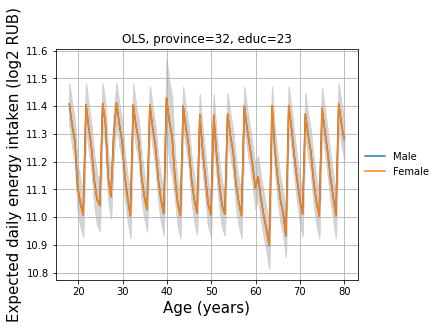

In [31]:
# Plot the estimated mean function (for log2 wages) for women and
# men over a range of ages, controlling for specific levels of
# status (region type), and educ (educational level).
for province in 32, 37, 41, 52:
    for educ in 23, 26, 29:
        conf_band(ols_result5, province=province, educ=educ, title="OLS")
        conf_band(gee_result5, province=province, educ=educ, title="GEE")

pdf.close()